###ACETONE_METHANOL_WILSON_PR EOS

Standard deviation of predicted temperatures of Acetone & Methanol system at 1.01325 bar based on Wilson equation and Peng-Robinson Equation of State from experimental results (Ind. Eng. Chem. 48, 142 (1956)) is 0.6056509789701628 K


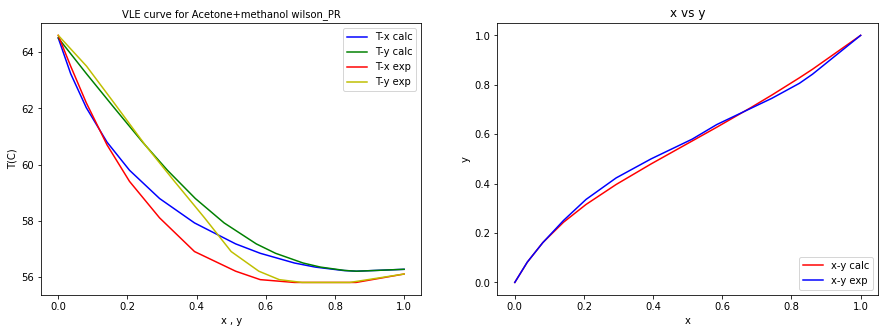

In [1]:
#ACETONE(1)/METHANOL(2) mix
from numpy import log,log10
import numpy as np
from numpy import exp
import matplotlib.pyplot as plt
import pandas as pd
import math

P = 1.01325 #bar
x1_exp =[0.0,0.036,0.081,0.141,0.206,0.293,0.394,0.513,0.584,0.683,0.743,0.823,0.861,1.0]
x1 = x1_exp
x2 = np.array([])
for i in x1:
    x2 = np.append(x2,1-i)   

#antoine constants
A1 = 4.42448
B1 = 1312.253
C1 = -32.445

A2 = 5.20409
B2 = 1581.341
C2 = -33.5

# initial guess of T

T1sat = (B1/(A1-log10(P)))-C1
T2sat =  (B2/(A2-log10(P)))-C2

Tinit = np.array([])
for i in x1:
    Tinit = np.append(Tinit,i*T1sat + (1-i)*T2sat)

data = {'x1':x1,'Tinit':Tinit}
df = pd.DataFrame(data)

df['phi1_init'] = pd.Series(np.repeat(1.0,14))
df['phi2_init'] = pd.Series(np.repeat(1.0,14))


P1sat_in = np.array([])
P2sat_in = np.array([])

for i in df.index:
    P1sat_in = np.append(P1sat_in, (10**(A1-(B1/(df['Tinit'][i]+C1)))))
    P2sat_in = np.append(P2sat_in, (10**(A2-(B2/(df['Tinit'][i]+C2)))))

df['P1sat_in']=pd.Series(P1sat_in*10**5)
df['P2sat_in']=pd.Series(P2sat_in*10**5)
#print(df['Tinit'])


#Wilson equations

Rdash = 1.9872  #cal/K.mol
A12 = 249.6   # (g12-g22)
A21 = 228.55       # (g21-g11)
v1 = 0.0000740 #m3/mol
v2 = 0.0000408 


G12 = np.array([])
G21 = np.array([])

for i in df.index:
    G12 = np.append(G12,(v2/v1)*exp(-A12/(Rdash*df['Tinit'][i])))
    G21 = np.append(G21,(v1/v2)*exp(-A21/(Rdash*df['Tinit'][i])))

df['G12'] = pd.Series(G12)
df['G21']=pd.Series(G21)

gamma1 = np.array([])
gamma2 = np.array([])

#NRTL equations

for i in df.index:
    gamma1 = np.append(gamma1,exp(-log(df['x1'][i]+df['G12'][i]*(1-df['x1'][i]))+(1-df['x1'][i])*((df['G12'][i]/(df['x1'][i]+df['G12'][i]*(1-df['x1'][i])))-(df['G21'][i]/(1-df['x1'][i]+df['G21'][i]*df['x1'][i])))))
    gamma2 =np.append(gamma2,exp(-log(1-df['x1'][i]+df['G21'][i]*df['x1'][i])-(df['x1'][i])*((df['G12'][i]/(df['x1'][i]+df['G12'][i]*(1-df['x1'][i])))-(df['G21'][i]/(1-df['x1'][i]+df['G21'][i]*df['x1'][i])))))


df['gamma1'] = pd.Series(gamma1)
df['gamma2']= pd.Series(gamma2)

#PR EQUATION
# exponential terms
exp1 = 1.0
exp2 = 1.0

# critical temp
Tc1 = np.repeat(508,14)                                     
Tc2 = np.repeat(513,14)
df['Tc1'] = pd.Series(Tc1)
df['Tc2'] = pd.Series(Tc2)

# critical pressure
Pc1 = np.repeat(48*10**5,14)                                     
Pc2 = np.repeat(81*10**5,14)
df['Pc1'] = pd.Series(Pc1)
df['Pc2'] = pd.Series(Pc2)
R= 8.314

# acentric factor values
om1 = np.repeat(0.304,14)                                     
om2 = np.repeat(0.556,14)
df['omega1'] = pd.Series(om1)
df['omega2'] = pd.Series(om2)

al1 = np.array([])
a1 = np.array([])
b1 = np.array([])

al2 = np.array([])
a2 = np.array([])
b2 = np.array([])

# these are for calculating phi-sat, PR equations

A1sat = np.array([])
A2sat = np.array([])
B1sat = np.array([])
B2sat = np.array([])

for i in df.index:
    al1=np.append(al1,(1+(0.37464+1.54226*df['omega1'][i]-0.26992*df['omega1'][i]**2)*(1-(df['Tinit'][i]/df['Tc1'][i])**0.5))**2)
      
    a1 = np.append(a1,(0.45724*(R*df['Tc1'][i])**2)/(df['Pc1'][i]))                 
                                 
    b1=  np.append(b1,(0.07780*R*df['Tc1'][i])/(df['Pc1'][i]))

    al2=np.append(al2,(1+(0.37464+1.54226*df['omega2'][i]-0.26992*df['omega2'][i]**2)*(1-(df['Tinit'][i]/df['Tc2'][i])**0.5))**2)
      
    a2 = np.append(a2,(0.45724*(R*df['Tc2'][i])**2)/(df['Pc2'][i]))                 
                                 
    b2=  np.append(b2,(0.07780*R*df['Tc2'][i])/(df['Pc2'][i]))

df['alpha1'] = pd.Series(al1)
df['a1'] = pd.Series(a1)
df['b1']=pd.Series(b1)
df['alpha2'] = pd.Series(al2)
df['a2'] = pd.Series(a2)
df['b2']=pd.Series(b2)

for i in df.index:
    A1sat =np.append(A1sat,df['alpha1'][i]*df['a1'][i]*df['P1sat_in'][i]/(R*df['Tinit'][i])**2)
   
    A2sat =np.append(A2sat,df['alpha2'][i]*df['a2'][i]*df['P2sat_in'][i]/(R*df['Tinit'][i])**2)
         
for i in df.index:
    B1sat = np.append(B1sat,((df['b1'][i])*df['P1sat_in'][i]/(R*df['Tinit'][i])))
    B2sat = np.append(B2sat,((df['b2'][i])*df['P2sat_in'][i]/(R*df['Tinit'][i])))

df['A1sat'] = pd.Series(A1sat)
df['B1sat'] = pd.Series(B1sat)
df['A2sat'] = pd.Series(A2sat)
df['B2sat'] = pd.Series(B2sat)
Za1sat = np.array([])
Za2sat = np.array([])

for i in df.index:

    Za1sat =np.append(Za1sat,np.roots([1,-(1-df['B1sat'][i]),(df['A1sat'][i]-2*df['B1sat'][i]-3*(df['B1sat'][i])**2),(-df['A1sat'][i]*df['B1sat'][i]-(df['B1sat'][i]**2)-(df['B1sat'][i]**3))]))
  
    
for i in df.index:    

    Za2sat =np.append(Za2sat,np.roots([1,-(1-df['B2sat'][i]),(df['A2sat'][i]-2*df['B2sat'][i]-3*(df['B2sat'][i])**2),(-df['A2sat'][i]*df['B2sat'][i]-(df['B2sat'][i]**2)-(df['B2sat'][i]**3))]))
  

#we define Z for both components,it is cubic equation and we find roots...

Z1sat = np.array([])
for i in Za1sat:
    if i>=0.5:
        Z1sat = np.append(Z1sat,i) 
Z2sat = np.array([])
for i in range(len(Z1sat)):
        Z2sat = np.append(Z2sat,Za2sat.real[3*i])      

df['Z1sat'] = pd.Series(Z1sat)
df['Z2sat'] = pd.Series(Z2sat)

#thus phi_sat can be found, all the correlations are available online for PR equation

phi1_sat = np.array([])
phi2_sat = np.array([])

for i in df.index:
    phi1_sat =np.append(phi1_sat,(exp(df['Z1sat'][i]-1.0-log(df['Z1sat'][i]-df['B1sat'][i])-(df['A1sat'][i]/(2*(2**0.5)*df['B1sat'][i]))*log((df['Z1sat'][i]+(1+(2**0.5))*df['B1sat'][i])/(df['Z1sat'][i]+(1-(2**0.5))*df['B1sat'][i])))))

for i in df.index:
    phi2_sat =np.append(phi2_sat,(exp(df['Z2sat'][i]-1.0-log(df['Z2sat'][i]-df['B2sat'][i])-(df['A2sat'][i]/(2*(2**0.5)*df['B2sat'][i]))*log((df['Z2sat'][i]+(1+(2**0.5))*df['B2sat'][i])/(df['Z2sat'][i]+(1-(2**0.5))*df['B2sat'][i])))))
df['phi1sat'] = pd.Series(phi1_sat)
df['phi2sat'] = pd.Series(phi2_sat)
#this is y1 from our assumed T

y1 = np.array([])
for i in df.index:
    y1 =np.append(y1,df['x1'][i]*df['gamma1'][i]*df['P1sat_in'][i]*df['phi1sat'][i]/(df['phi1_init'][i]*P*10**5))
         
df['y1']=pd.Series(y1)

y2 = np.array([])
for i in y1:
    y2 = np.append(y2,1-i)
df['y2']=pd.Series(y2)

#loop starts here

for j in df.index:

    while True:
    
        P1sat_g = np.array([])
        for i in df.index:
            P1sat_g =np.append(P1sat_g,(((df['phi1sat'][i]*df['x1'][i]*df['gamma1'][i])/(df['phi1_init'][i]*P*10**5))+((df['phi2sat'][i]*(1-df['x1'][i])*df['gamma2'][i]*(df['P2sat_in'][i]/df['P1sat_in'][i]))/(df['phi2_init'][i]*P*10**5)))**(-1))

        df['P1sat_g']=pd.Series(P1sat_g)
        
# Next T can be found 
        
        Tnext = np.array([])
        for i in df.index:
            Tnext = np.append(Tnext,(B1/(A1-log10(df['P1sat_g'][i]/10**5)))-C1)

        df['Tnext']=pd.Series(Tnext)
        
# From obtained T, find P1sat and P2sat

        P1sat_nx = np.array([])
        P2sat_nx = np.array([])

        for i in df.index:
            P1sat_nx = np.append(P1sat_nx, (10**(A1-(B1/(df['Tnext'][i]+C1)))))
            P2sat_nx = np.append(P2sat_nx, (10**(A2-(B2/(df['Tnext'][i]+C2)))))

        df['P1sat_nx']=pd.Series(P1sat_nx*10**5)
        df['P2sat_nx']=pd.Series(P2sat_nx*10**5)

#gamma values for new T

        G12nx = np.array([])
        G21nx = np.array([])

        for i in df.index:
            G12nx = np.append(G12nx,(v2/v1)*exp(-A12/(Rdash*df['Tnext'][i])))
            G21nx = np.append(G21nx,(v1/v2)*exp(-A21/(Rdash*df['Tnext'][i])))

        df['G12nx'] = pd.Series(G12nx)
        df['G21nx']=pd.Series(G21nx)

        gamma1nx = np.array([])
        gamma2nx = np.array([])

        #Wilson equations

        for i in df.index:
            gamma1nx = np.append(gamma1nx,exp(-log(df['x1'][i]+df['G12nx'][i]*(1-df['x1'][i]))+(1-df['x1'][i])*((df['G12nx'][i]/(df['x1'][i]+df['G12nx'][i]*(1-df['x1'][i])))-(df['G21nx'][i]/(1-df['x1'][i]+df['G21nx'][i]*df['x1'][i])))))
            gamma2nx =np.append(gamma2nx,exp(-log(1-df['x1'][i]+df['G21nx'][i]*df['x1'][i])-(df['x1'][i])*((df['G12nx'][i]/(df['x1'][i]+df['G12nx'][i]*(1-df['x1'][i])))-(df['G21nx'][i]/(1-df['x1'][i]+df['G21nx'][i]*df['x1'][i])))))
        
        df['gamma1nx'] = pd.Series(gamma1nx)
        df['gamma2nx']= pd.Series(gamma2nx)

# phi_sat values for new T

        al1_nx = np.array([])
        a1_nx = np.array([])
        b1_nx = np.array([])

        al2_nx = np.array([])
        a2_nx = np.array([])
        b2_nx = np.array([])

# these are for calculating phi-sat, only change is in replacing Pinit by Psat

        A1sat_nx = np.array([])
        A2sat_nx = np.array([])
        B1sat_nx = np.array([])
        B2sat_nx = np.array([])

        for i in df.index:
            al1_nx=np.append(al1_nx,(1+(0.37464+1.54226*df['omega1'][i]-0.26992*df['omega1'][i]**2)*(1-(df['Tnext'][i]/df['Tc1'][i])**0.5))**2)
      
            a1_nx = np.append(a1_nx,(0.45724*(R*df['Tc1'][i])**2)/(df['Pc1'][i]))   
                                               
            b1_nx=  np.append(b1_nx,(0.07780*R*df['Tc1'][i])/(df['Pc1'][i]))
 
            al2_nx=np.append(al2_nx,(1+(0.37464+1.54226*df['omega2'][i]-0.26992*df['omega2'][i]**2)*(1-(df['Tnext'][i]/df['Tc2'][i])**0.5))**2)
      
            a2_nx = np.append(a2_nx,(0.45724*(R*df['Tc2'][i])**2)/(df['Pc2'][i]))   
                                               
            b2_nx=  np.append(b2_nx,(0.07780*R*df['Tc2'][i])/(df['Pc2'][i]))



        df['alpha1nx'] = pd.Series(al1_nx)
        df['a1nx'] = pd.Series(a1_nx)
        df['b1nx']=pd.Series(b1_nx)
        df['alpha2nx'] = pd.Series(al2_nx)
        df['a2nx'] = pd.Series(a2_nx)
        df['b2nx']=pd.Series(b2_nx)


        for i in df.index:
            A1sat_nx =np.append(A1sat_nx,df['alpha1nx'][i]*df['a1nx'][i]*df['P1sat_nx'][i]/(R*df['Tnext'][i])**2)
   
            A2sat_nx =np.append(A2sat_nx,df['alpha2nx'][i]*df['a2nx'][i]*df['P2sat_nx'][i]/(R*df['Tnext'][i])**2)
         
        for i in df.index:
            B1sat_nx =np.append(B1sat_nx,((df['b1nx'][i])*df['P1sat_nx'][i]/(R*df['Tnext'][i])))
            B2sat_nx =np.append(B2sat_nx,((df['b2nx'][i])*df['P2sat_nx'][i]/(R*df['Tnext'][i])))


        df['A1satnx'] = pd.Series(A1sat_nx)
        df['B1satnx'] = pd.Series(B1sat_nx)
        df['A2satnx'] = pd.Series(A2sat_nx)
        df['B2satnx'] = pd.Series(B2sat_nx)

        Za1sat_nx = np.array([])
        Za2sat_nx = np.array([])

        for i in df.index:

            Za1sat_nx =np.append(Za1sat_nx,np.roots([1,-(1-df['B1satnx'][i]),(df['A1satnx'][i]-2*df['B1satnx'][i]-3*(df['B1satnx'][i])**2),(-df['A1satnx'][i]*df['B1satnx'][i]-(df['B1satnx'][i]**2)-(df['B1satnx'][i]**3))]))
  
            
        for i in df.index:    

            Za2sat_nx =np.append(Za2sat_nx,np.roots([1,-(1-df['B2satnx'][i]),(df['A2satnx'][i]-2*df['B2satnx'][i]-3*(df['B2satnx'][i])**2),(-df['A2satnx'][i]*df['B2satnx'][i]-(df['B2satnx'][i]**2)-(df['B2satnx'][i]**3))]))
  

#we define Z for both components,it is cubic equation and we find roots...


        Z1sat_nx = np.array([])
        for i in Za1sat_nx:
            if i>=0.5:
                Z1sat_nx = np.append(Z1sat_nx,i) 
        Z2sat_nx = np.array([])
        for i in range(len(Z1sat)):
                Z2sat_nx = np.append(Z2sat_nx,Za2sat_nx.real[3*i])      

        df['Z1satnx'] = pd.Series(Z1sat_nx)
        df['Z2satnx'] = pd.Series(Z2sat_nx)

#thus phi can be found, all the correlations are available online for PR equation

        phi1_satnx = np.array([])
        phi2_satnx = np.array([])

        for i in df.index:
            phi1_satnx =np.append(phi1_satnx,(exp(df['Z1satnx'][i]-1.0-log(df['Z1satnx'][i]-df['B1satnx'][i])-(df['A1satnx'][i]/(2*(2**0.5)*df['B1satnx'][i]))*log((df['Z1satnx'][i]+(1+(2**0.5))*df['B1satnx'][i])/(df['Z1satnx'][i]+(1-(2**0.5))*df['B1satnx'][i])))))

        for i in df.index:
            phi2_satnx =np.append(phi2_satnx,(exp(df['Z2satnx'][i]-1.0-log(df['Z2satnx'][i]-df['B2satnx'][i])-(df['A2satnx'][i]/(2*(2**0.5)*df['B2satnx'][i]))*log((df['Z2satnx'][i]+(1+(2**0.5))*df['B2satnx'][i])/(df['Z2satnx'][i]+(1-(2**0.5))*df['B2satnx'][i])))))
        df['phi1satnx'] = pd.Series(phi1_satnx)
        df['phi2satnx'] = pd.Series(phi2_satnx)

# phi values for new T

        A1nx = np.array([])
        B1nx = np.array([])
        A2nx = np.array([])
        B2nx = np.array([])

        for i in df.index:
                A1nx =np.append(A1nx,df['alpha1nx'][i]*df['a1nx'][i]*P*10**5/(R*df['Tnext'][i])**2)
   
                A2nx =np.append(A2nx,df['alpha2nx'][i]*df['a2nx'][i]*P*10**5/(R*df['Tnext'][i])**2)
         
        for i in df.index:
                B1nx = np.append(B1nx,((df['b1nx'][i])*P*10**5/(R*df['Tnext'][i])))
                B2nx = np.append(B2nx,((df['b2nx'][i])*P*10**5/(R*df['Tnext'][i])))
                

        df['A1nx'] = pd.Series(A1nx)
        df['B1nx'] = pd.Series(B1nx)
        df['A2nx'] = pd.Series(A2nx)
        df['B2nx'] = pd.Series(B2nx)
        # print(df)
        Za1nx = np.array([])
        Za2nx = np.array([])


        for i in df.index:

            Za1nx =np.append(Za1nx,np.roots([1,-(1-df['B1nx'][i]),(df['A1nx'][i]-2*df['B1nx'][i]-3*(df['B1nx'][i])**2),(-df['A1nx'][i]*df['B1nx'][i]-(df['B1nx'][i]**2)-(df['B1nx'][i]**3))]))
  

        for i in df.index:    

            Za2nx =np.append(Za2nx,np.roots([1,-(1-df['B2nx'][i]),(df['A2nx'][i]-2*df['B2nx'][i]-3*(df['B2nx'][i])**2),(-df['A2nx'][i]*df['B2nx'][i]-(df['B2nx'][i]**2)-(df['B2nx'][i]**3))]))
  


##we define Z for both components,it is cubic equation and we find roots...


        Z1nx = np.array([])
        for i in Za1nx:
            if i>=0.5:
                Z1nx = np.append(Z1nx,i) 
        Z2nx = np.array([])
        for i in range(len(Z1nx)):
                Z2nx = np.append(Z2nx,Za2nx.real[3*i])      

        df['Z1nx'] = pd.Series(Z1nx)
        df['Z2nx'] = pd.Series(Z2nx)

        #thus phi can be found, all the correlations are available online for PR equation

        phi1_next = np.array([])
        phi2_next = np.array([])

        for i in df.index:
            phi1_next =np.append(phi1_next,(exp(df['Z1nx'][i]-1.0-log(df['Z1nx'][i]-df['B1nx'][i])-(df['A1nx'][i]/(2*(2**0.5)*df['B1nx'][i]))*log((df['Z1nx'][i]+(1+(2**0.5))*df['B1nx'][i])/(df['Z1nx'][i]+(1-(2**0.5))*df['B1nx'][i])))))
        for i in df.index:
            phi2_next =np.append(phi2_next,(exp(df['Z2nx'][i]-1.0-log(df['Z2nx'][i]-df['B2nx'][i])-(df['A2nx'][i]/(2*(2**0.5)*df['B2nx'][i]))*log((df['Z2nx'][i]+(1+(2**0.5))*df['B2nx'][i])/(df['Z2nx'][i]+(1-(2**0.5))*df['B2nx'][i])))))

        df['phi1_next']=pd.Series(phi1_next)
        df['phi2_next']=pd.Series(phi2_next)

#  y1 values for new T

        y1nx = np.array([])
        for i in df.index:
            y1nx =np.append(y1nx,df['x1'][i]*df['gamma1nx'][i]*df['P1sat_nx'][i]*df['phi1satnx'][i]/(df['phi1_next'][i]*P*10**5))
         
        df['y1nx']=pd.Series(y1nx)

        y2nx = np.array([])
        for i in y1nx:
            y2nx = np.append(y2nx,1-i)
        df['y2nx']=pd.Series(y2nx)


        df['deltaT'] = pd.Series(df['Tinit']-df['Tnext'])
        
#  Since T is decreasing for each iteration, we gave convergence such that difference in initial and final is small

        if df.loc[j,'deltaT']>0.0001:

            df['Tinit'] = df['Tinit'].replace(df['Tinit'][j],df['Tnext'][j])
            df['phi1sat']=df['phi1sat'].replace(df['phi1sat'][j],df['phi1satnx'][j])
            df['gamma1']=df['gamma1'].replace(df['gamma1'][j],df['gamma1nx'][j])
            df['phi1_init']=df['phi1_init'].replace(df['phi1_init'][j],df['phi1_next'][j])
            df['phi2sat']=df['phi2sat'].replace(df['phi2sat'][j],df['phi2satnx'][j])
            df['gamma2']=df['gamma2'].replace(df['gamma2'][j],df['gamma2nx'][j])
            df['P1sat_in']=df['P1sat_in'].replace(df['P1sat_in'][j],df['P1sat_nx'][j])
            df['P2sat_in']=df['P2sat_in'].replace(df['P2sat_in'][j],df['P2sat_nx'][j])
            df['phi2_init']=df['phi2_init'].replace(df['phi2_init'][j],df['phi2_next'][j])
            # print(df['y1nx'][j])
            # print(df['P1sat_g'][j])
            # print(df['Tinit'][j])
            # print(df['Tnext'][j])
        else:
            break


# print(df['Tnext'])
# print(df['deltaT'])
# print(df['y1'])
# print(df['y1nx'])
        
# We need to plot Tnext vs x1 and y1nx... And experimental values of T vs x1 and y1

# calculated values

T_calc = np.array([])
for i in df.index:
    T_calc = np.append(T_calc,df['Tnext'][i]-273.15)
y1_calc = np.array(y1nx)

# calculated values

T_exp = [64.6,63.5,62.2,60.7,59.4,58.1,56.9,56.2,55.9,55.8,55.8,55.8,55.8,56.1]

y1_exp = [0,0.082,0.161,0.251,0.336,0.423,0.5,0.580,0.639,0.705,0.745,0.806,0.843,1.0]

# graphs
error = T_exp - T_calc
#print(error)
sumsq = 0
for i in range(14):
    sumsq = sumsq + (error[i])**2
stdev = math.sqrt(sumsq/(len(T_exp)-1))
print("Standard deviation of predicted temperatures of Acetone & Methanol system at 1.01325 bar based on Wilson equation and Peng-Robinson Equation of State from experimental results (Ind. Eng. Chem. 48, 142 (1956)) is",stdev,"K")


fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
ax1.plot(x1,T_calc,'b-')

ax1.plot(y1_calc,T_calc,'g-')
ax1.plot(x1_exp,T_exp,'r-')
ax1.plot(y1_exp,T_exp,'y-')
ax1.set_title('VLE curve for Acetone+methanol wilson_PR',size = 10)
ax1.set_xlabel('x , y')
ax1.set_ylabel('T(C)')
ax1.legend(labels = ('T-x calc','T-y calc','T-x exp','T-y exp'),loc = 'upper right')

ax2 = fig.add_subplot(122)
ax2.plot(x1,y1_calc,'r-')
ax2.plot(x1_exp,y1_exp,'b-')
ax2.set_title('x vs y')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.legend(labels=('x-y calc','x-y exp'),loc = 'lower right')
plt.show()

               